In [1]:
from covid.simulator import Population
from covid.auxilliary import symptom_names
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from covid.policy import Policy

In [2]:
genome_names = ['genome' + str(i) for i in range(128)]
comorbiditie_names = ['asthma', 'obesity', 'smoking', 'diabetes', 
    'heart_disease', 'hypertension']
vaccination_status_names = ['vaccine_1', 'vaccine_2', 'vaccine_3']
symptomNames = ['covid_recovered','covid_positive', 'no_taste_smell',
    'fever','headache', 'pneumonia','stomach','myocarditis', 'blood_clots','death']

feature_names = symptomNames + ['age', 'gender','income'] + genome_names + comorbiditie_names + vaccination_status_names

# Helper indexes
symptom_indexes = np.array(range(len(symptomNames)))
age_gender_income_indexes = np.array(range(len(symptomNames), len(symptomNames)+3))
genome_indexes = np.array(range(len(symptomNames) + 3, len(symptomNames) + 3 + len(genome_names)))
comorbiditie_indexes = np.array(range(len(symptomNames) + 3 + len(genome_names), 
    len(symptomNames)+3 + len(genome_names) + len(comorbiditie_names)))
print(symptom_indexes)
print(age_gender_income_indexes)
print(genome_indexes)
print(comorbiditie_indexes)



[0 1 2 3 4 5 6 7 8 9]
[10 11 12]
[ 13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30
  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140]
[141 142 143 144 145 146]


# Utility function weights

In [3]:
#covid_recovered, covid_positive, no_taste_smell, fever, headache, pneumonia, stomach, myocarditis, blood_clots, death
w = np.array([0, 0.2, 0.1, 0.1, 0.1, 0.5, 0.2, 0.5, 1.0, 100])
assert w.shape[0] == 10, 'Shape of weights does not fit number of symptoms'

In [4]:
class BetaBernoulliModel:
    def __init__(self, nsymptom, nvacc):
        # Priors for the beta-bernoulli model
        self.a = np.ones(shape=[nvacc, nsymptom])/2 # using jeffreys prior
        self.b = np.ones(shape=[nvacc, nsymptom])/2 # using jeffreys prior
        self.nvacc = nvacc
        self.nsymptom = nsymptom

    def update(self, features, actions, outcomes):
        """
        for index in range(self.nvacc):
            print(outcomes[np.where(actions == (index-1))]) 
            print(actions)
            print(outcomes)
            if (np.sum(outcomes[np.where(actions == index - 1)], axis=1).size != 0):
                self.a[index] += np.sum(outcomes[np.where(actions == index - 1)], axis=1)
                self.b[index] += np.sum(outcomes[np.where(actions == index - 1)]==0, axis=1)\
                    - np.sum(outcomes[np.where(actions == index - 1)], axis=1)
            else: 
                self.b[index] += np.sum((outcomes==0)[np.where(actions == index - 1)], axis=1)
        """

        # performing the update to the beta - Bernoulli model for each case
        # in a loop. i.e. when |y| = 1
        # TODO: vecotirze this / fix the code above
        for index, outcome in enumerate(outcomes):
            self.a[int(actions[index])] += outcome
            self.b[int(actions[index])] += 1 - outcome

    def get_params(self):
        # Returns the parameters of all the beta distrobutions.
        return self.a, self.b


    def get_prob(self, features, action):
        # Returns the maximum posterior estiamte / mean of the theta-distrobution
        # which is a/(a+b) where a and b are the posterior parameters
        return self.a[action] / (self.a[action] + self.b[action])

    
    def retrain(self, features, actions, outcomes):
        # Retrains the model using jeffreys prior. The input should be the complete 
        # database of the trials etc. (This overwrites the old model)
        # With no privacy guarantee, this is equivivalent to continously update the model
        # However if we add laplace noise, then this would be a centralized method
        # as opposed to the local method which 'update' employs

        self.a = np.ones(shape=[self.nvacc, self.nsymptom])/2 # using jeffreys prior
        self.b = np.ones(shape=[self.nvacc, self.nsymptom])/2 # using jeffreys prior

        self.update(features, actions, outcomes)
    
    def set_default_action(self, action):
        self.default_action = action
    
    def set_default_symptom(self, symptom):
        self.default_symptom = symptom

    def predict(self, X):
        probs = self.get_prob(X, self.default_action)[:,self.default_symptom]
        return (probs > 0.5).astype(int)


In [5]:
from sklearn.linear_model import LogisticRegression
class LogisticModel:
    def __init__(self, nsymptom, nvacc):
        self.nvacc = nvacc
        self.nsymptom = nsymptom
        self.untrainedFlag = True

        # we dont predict on all the columns, here is an array of the selected ones
        self.columns = np.concatenate([symptom_indexes, 
            age_gender_income_indexes, 
            comorbiditie_indexes])
        print(self.columns)
        
        self.models = []
        for _ in range(nvacc):
            ls = [ [None] for i in range(nsymptom) ]
            self.models.append(ls)

    def update(self, features, actions, outcomes):
        # First iteration creates the variables
        if self.untrainedFlag:  
            self.untrainedFlag = False
            self.X = features[:, self.columns]
            self.Y = outcomes
            self.A = actions

        # Append to the saved arrays
        else:
            self.X = np.append(self.X, features[:, self.columns], axis=0)
            self.Y = np.append(self.Y, outcomes, axis=0)
            self.A = np.append(self.A, actions, axis=0)

        #print('training:')
        for index, a in enumerate(self.models):
            for jndex, s in enumerate(a):
                #print(f'vaccine: {index}, symptom: {jndex} - {symptomNames[jndex]}')
                self.models[index][jndex] = make_logit(self.X, self.Y[:, jndex])



    def get_params(self):
        print('Not implemented yet!!!')
        pass

    def get_prob(self, features, action):
        # Takes a single induviduals features and an action and returns the
        # probability of each symptom
        features = features[self.columns]
        res = np.zeros(shape=[features.shape[0], self.nsymptom])
        for index, model in enumerate(self.models[action]):
            if model is not None:
                res[index] = model.predict_proba(features.reshape(1, -1))[:,0]
                
        return res

    
    def retrain(self, features, actions, outcomes):
        # retrains the model from scratch
        self.untrainedFlag = True
        self.update(features, actions, outcomes)

# Helper function to make a logistic regression model
def make_logit(X, Y):
    if Y.sum() == 0:
        return None
    model = LogisticRegression(penalty='l1', C=0.1, solver='saga')
    return model.fit(X, Y)

In [6]:
class Naive(Policy):
    def get_utility(self, features, action, outcome):
        utility = 0
        for t, o in enumerate(outcome):
            utility -= np.dot(w, o)*(1+int(action[t] != -1))
       
        return utility

    def set_model(self, model):
        # the model needs to have a get_prob function which returns the probabilities of
        # each induvidual symptom

        self.model = model
    
    def get_action(self, features):
        """Get a completely random set of actions, but only one for each individual.

        If there is more than one individual, feature has dimensions t*x matrix, otherwise it is an x-size array.
        
        It assumes a finite set of actions.

        Returns:
        A t*|A| array of actions
        """
      
        
        n_obs = features.shape[0]
        actions = np.zeros(n_obs)
        
        for index, t in enumerate(features):
            u_list = []
            for a in self.action_set:
                u_list.append(self.get_expected_utility(a, t))
            actions[index] = np.argmax(np.array(u_list))
        return actions

    def get_expected_utility(self, action, features):
        p = self.model.get_prob(features, action)
        
        return -np.dot(p, w)*(1+int(action != -1))

    def observe(self, features, action, outcomes):
        self.model.update(features, action, outcomes)

        

In [7]:
class NaiveWithTrial(Policy):
    def __init__(self, n_actions, action_set):
        super().__init__(n_actions, action_set)
        self.trials = -1

    def get_utility(self, features, action, outcome):
        utility = 0
        for t, o in enumerate(outcome):
            utility -= np.dot(w, o)*(1+int(action[t] != -1))
       
        return utility

    def set_model(self, model):
        self.model = model
    
    def get_action(self, features):
        """Get a completely random set of actions, but only one for each individual.

        If there is more than one individual, feature has dimensions t*x matrix, otherwise it is an x-size array.
        
        It assumes a finite set of actions.

        Returns:
        A t*|A| array of actions
        """
      
        
        n_obs = features.shape[0]
        actions = np.zeros(n_obs)
        
        if self.trials > 0:
            print('Random trial')
            self.trials -= n_obs
            for i in range(n_obs):
                actions[i] = np.random.choice(self.action_set)
            
            return actions

        for index, t in enumerate(features):
            u_list = []
            for a in self.action_set:
                u_list.append(self.get_expected_utility(a, t))
            actions[index] = np.argmax(np.array(u_list)) - 1
            print(u_list)
        return actions

    def get_expected_utility(self, action, features):
        p = self.model.get_prob(features, action)
        return -np.dot(p, w)*(1+int(action != -1))

    def observe(self, features, action, outcomes):
        self.model.update(features, action, outcomes)
    
    def set_trial(self, n_trials: int):
        # defines the size of the random trail at the beginning
        self.trials = n_trials
        
        

In [8]:
def privacy_tradeoff(epsilon, policy):
    # Returns the loss in uility given a privacy guarantee of epsilon
    # Either absolute or relative
    pass

In [9]:
## Baseline simulator parameters
n_genes = 128
n_vaccines = 3 # DO NOT CHANGE, breaks the simulator.
n_treatments = 4
n_population = 10_000
n_symptoms = 10
batch_size = 2000

assert n_population/batch_size == n_population//batch_size, 'the batch size must evenly divide the number of people'


# symptom names for easy reference
from covid.auxilliary import symptom_names

In [10]:
# Setting the population generator
population = Population(n_genes, n_vaccines, n_treatments)


In [11]:
X = population.generate(n_population)
n_features = X.shape[1]


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [12]:
import sklearn as sk
import warnings

from warnings import filterwarnings
filterwarnings('ignore')


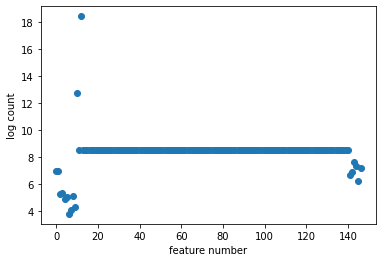

In [13]:
# Plotting data for some intution
plt.scatter(range(150),np.log(np.sum(X, axis=0)))
plt.ylabel('log count')
plt.xlabel('feature number')
None


# Running our policy in a loop
To test our policy, we can loop over every individual in the population 'X' and decide on the action and observe the outcome

In [14]:
# These are the possbile actions, currently restricted to -1, which is
# No vaccine, and 0, which is a vaccine
action_space = np.array([-1,1])
nactions = action_space.shape[0]

# Initializing our policy with the number of actions and
vaccine_policy = NaiveWithTrial(nactions, action_space)
vaccine_policy.set_trial(1999)

# Here we set our predictive model
#vaccine_policy.set_model(LogisticModel(n_symptoms, nactions))
vaccine_policy.set_model(BetaBernoulliModel(n_symptoms, nactions))

# Arrays to store the actions and outcomes for each
Y = np.zeros((n_population, n_symptoms))
A = np.zeros(n_population)

if batch_size == 1:
    for t in range(n_population):
        #print("Person nr: ", t)
        a_t = vaccine_policy.get_action(X[t].reshape((1, n_features)))
        # Then you can obtain results for everybody
        y_t = population.vaccinate([t], a_t.reshape((1, 1)))
        # Feed the results back in your policy. This allows you to fit the
        # statistical model you have.
        vaccine_policy.observe(X[t], a_t, y_t)

        # Saving action taken and outcome obtained.
        Y[t] = y_t
        A[t] = a_t
else:
    for b in range(n_population//batch_size):
        print("Batch nr: ", b)
        start = b*batch_size
        stop = (b+1) * batch_size
        indexes = np.arange(start, stop, step=1).astype(int)

        a = vaccine_policy.get_action(X[indexes]).astype(int)
        #print(a)
        # Then you can obtain results for everybody
        y = population.vaccinate(indexes, a.reshape(batch_size, 1))

        # Feed the results back in your policy. This allows you to fit the
        # statistical model you have.
        vaccine_policy.observe(X[indexes], a, y)

        # Saving action taken and outcome obtained.
        Y[indexes] = y
        A[indexes] = a



Initialising policy with  2 actions
A = { [-1  1] }
Batch nr:  0
Random trial
TOTAL VACCINATED: 1
TOTAL VACCINATED: 2
TOTAL VACCINATED: 3
TOTAL VACCINATED: 4
TOTAL VACCINATED: 5
TOTAL VACCINATED: 6
TOTAL VACCINATED: 7
TOTAL VACCINATED: 8
TOTAL VACCINATED: 9
TOTAL VACCINATED: 10
TOTAL VACCINATED: 11
TOTAL VACCINATED: 12
TOTAL VACCINATED: 13
TOTAL VACCINATED: 14
TOTAL VACCINATED: 15
TOTAL VACCINATED: 16
TOTAL VACCINATED: 17
TOTAL VACCINATED: 18
TOTAL VACCINATED: 19
TOTAL VACCINATED: 20
TOTAL VACCINATED: 21
TOTAL VACCINATED: 22
TOTAL VACCINATED: 23
TOTAL VACCINATED: 24
TOTAL VACCINATED: 25
TOTAL VACCINATED: 26
TOTAL VACCINATED: 27
TOTAL VACCINATED: 28
TOTAL VACCINATED: 29
TOTAL VACCINATED: 30
TOTAL VACCINATED: 31
TOTAL VACCINATED: 32
TOTAL VACCINATED: 33
TOTAL VACCINATED: 34
TOTAL VACCINATED: 35
TOTAL VACCINATED: 36
TOTAL VACCINATED: 37
TOTAL VACCINATED: 38
TOTAL VACCINATED: 39
TOTAL VACCINATED: 40
TOTAL VACCINATED: 41
TOTAL VACCINATED: 42
TOTAL VACCINATED: 43
TOTAL VACCINATED: 44
TOTAL V

In [25]:
population.NUMBEROFVACCINATED

1027

Accumulated utility for the policy run: -16750.400000000333
Average utility for the policy run: -1.6750400000000332


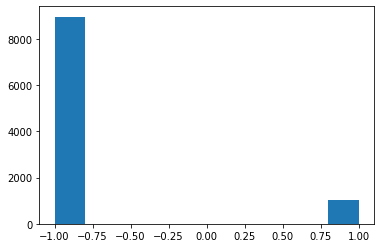

In [15]:
plt.hist(A)

#plt.scatter(range(150),np.sum(X, axis=0))
print('Accumulated utility for the policy run:', vaccine_policy.get_utility(X, A, Y))
print('Average utility for the policy run:', vaccine_policy.get_utility(X, A, Y)/n_population)

In [16]:
def print_pre_statistics(X):
    print(f'Statistic (N={X.shape[0]})')
    for i in range(len(symptom_names)-1):
        print(f'{symptom_names[i].ljust(15)} {X[:, i].sum()}')


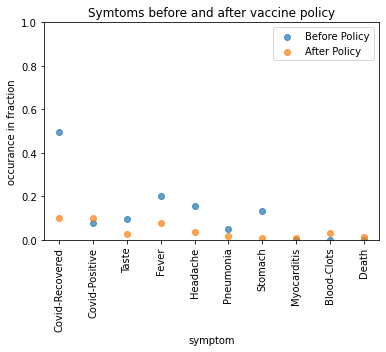

In [17]:
def plot_symptom_occurence(symptoms, label=None, ylim=[0,1],title=None):
    plt.scatter(range(n_symptoms), symptoms.sum(axis=0)/symptoms.shape[0], label=label, alpha=0.7)
    plt.xticks(range(n_symptoms), labels=symptom_names, rotation=90)
    plt.ylabel('occurance in fraction')
    plt.xlabel('symptom')
    if ylim is not None:
        plt.ylim(ylim)
    if title is not None:
        plt.title(title)



plot_symptom_occurence(X[:, -10:], label='Before Policy')
plot_symptom_occurence(Y, label='After Policy', title='Symtoms before and after vaccine policy')
plt.legend()
None

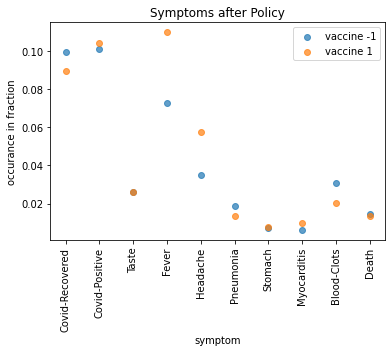

In [18]:
def plot_symptom_occurence_vaccine(symptoms, actions, label=None):

    for a in action_space:
        s = symptoms[np.where(actions == a)]
        plot_symptom_occurence(s, label=f'vaccine {a}', ylim=None)
        plt.title('Symptoms after Policy')
    plt.legend()
    
plot_symptom_occurence_vaccine(Y, A)

In [19]:
# Getting model paramters and plotting expectation

a, b = vaccine_policy.model.get_params()
c = a[0]/(a[0] + b[0])
v = a[1]/(a[1] + b[1])


In [20]:
print('NO VACCINE:')
for index, val in enumerate(c):
    print(f'{symptomNames[index].ljust(18)}{val:.6f}')

NO VACCINE:
covid_recovered   0.500000
covid_positive    0.500000
no_taste_smell    0.500000
fever             0.500000
headache          0.500000
pneumonia         0.500000
stomach           0.500000
myocarditis       0.500000
blood_clots       0.500000
death             0.500000


In [21]:
print('VACCINE:')
for index, val in enumerate(v):
    print(f'{symptomNames[index].ljust(18)}{val:.6f}')
    

VACCINE:
covid_recovered   0.098540
covid_positive    0.101540
no_taste_smell    0.026047
fever             0.076542
headache          0.037546
pneumonia         0.018048
stomach           0.007049
myocarditis       0.006549
blood_clots       0.029547
death             0.014549


In [22]:
print(np.mean(Y, axis=0))

[0.0985 0.1015 0.026  0.0765 0.0375 0.018  0.007  0.0065 0.0295 0.0145]


In [23]:
print(np.sum(Y, axis=0))
#plt.scatter(range(150),np.sum(X, axis=0))
print('Accumulated utility for the policy run:', vaccine_policy.get_utility(X, A, Y))



[ 985. 1015.  260.  765.  375.  180.   70.   65.  295.  145.]
Accumulated utility for the policy run: -16750.400000000333


In [24]:
all1 = np.ones(shape=[X.shape[1]])
all0 = np.zeros(shape=[X.shape[1]])

m = vaccine_policy.model
for i in range(len(m.models)):
    for j in range(len(m.models[0])):
        print(m.models[i][j].predict_proba(all0.reshape(1, -1))[0,0])


AttributeError: 'BetaBernoulliModel' object has no attribute 'models'

# FAIRNESS
Assume we have a set of features $X$, a set of actions taken $A$, and a set of outcomes $Y$. Make a function that accepts these numpy arrays and calculates the equal-op score using this list of sensitive variables.


In [ ]:
sensitive_control_variables = ['gender', 'income']

In [ ]:
def equal_op(X, A, Y, Z=sensitive_control_variables):
    scores = np.zeros(len(Z))

    for z in Z:
        pass


    return scores
